In [1]:
import pandas as pd
import numpy as np
import itertools
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Investigating Fake News Detection with Scikit-Learn

Detecting so-called "fake news" is no easy task. First, there is defining what fake news is -- given it has now become a political statement. If you can find or agree upon a definition, then you must collect and properly label real and fake news (hopefully on similar topics to best show clear distinctions). Once collected, you must then find useful features to determine fake from real news. 

For a more in-depth look at this problem space, I recommend taking a look at Miguel Martinez-Alvarez's post ["How can Machine Learning and AI Help Solve the Fake News Problem"](https://miguelmalvarez.com/2017/03/23/how-can-machine-learning-and-ai-help-solving-the-fake-news-problem/).

Around the same time I read Miguel's insightful post, I came across an open data science post about [building a successful fake news detector with Bayesian models](https://opendatascience.com/blog/how-to-build-a-fake-news-classification-model/). The author even created a [repository with the dataset of tagged fake and real news examples](https://github.com/GeorgeMcIntire/fake_real_news_dataset). I was curious if I could easily reproduce the results, and if I could then determine what the model had learned. 

In this notebook, we'll walk through some of my initial exploration together and see if you can build a successful fake news detector!

### Data Exploration

To begin, you should always take a quick look at the data and get a feel for its contents. To do so, use a Pandas DataFrame and check the shape, head and apply any necessary transformations.

In [3]:
df = pd.read_csv('fake_or_real_news.csv')

In [4]:
df.shape

(6335, 4)

In [5]:
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [6]:
df = df.set_index('Unnamed: 0')

In [7]:
df.head()

,title,text,label
Unnamed: 0,,,
8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


### Extracting the training data

Now that the DataFrame looks closer to what you need, you want to separate the labels and set up training and test datasets. 

For this notebook, I decided to focus on using the longer article text. Because I knew I would be using bag-of-words and Term Frequency–Inverse Document Frequency (TF-IDF) to extract features, this seemed like a good choice. Using longer text will hopefully allow for distinct words and features for my real and fake news data.

In [8]:
y = df.label

In [9]:
df = df.drop('label', axis=1)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], y, test_size=0.33, random_state=53)

### Building Vectorizer Classifiers

Now that you have your training and testing data, you can build your classifiers. To get a good idea if the words and tokens in the articles had a significant impact on whether the news was fake or real, you begin by using `CountVectorizer` and `TfidfVectorizer`.  

You'll see the example has a max threshhold set at `.7` for the TF-IDF vectorizer `tfidf_vectorizer` using the `max_df` argument. This removes words which appear in more than 70% of the articles. Also, the built-in `stop_words` parameter will remove English stop words from the data before making vectors. 

There are many more parameters avialable and you can read all about them in the scikit-learn documentation for [`TfidfVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) and [`CountVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html).

In [11]:
count_vectorizer = CountVectorizer(stop_words='english')
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)

In [12]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

Now that you have vectors, you can then take a look at the vector features, stored in `count_vectorizer` and `tfidf_vectorizer`. 

Are there any noticable issues? (Yes!)

There are clearly comments, measurements or other nonsensical words as well as multilingual articles in the dataset that you have been using. Normally, you would want to spend more time preprocessing this and removing noise, but as this tutorial just showcases a small proof of concept, we will see if the model can overcome the noise and properly classify despite these issues.

In [13]:
tfidf_vectorizer.get_feature_names()[-10:]

['حلب', 'عربي', 'عن', 'لم', 'ما', 'محاولات', 'من', 'هذا', 'والمرضى', 'ยงade']

In [14]:
count_vectorizer.get_feature_names()[:10]

['00',
 '000',
 '0000',
 '00000031',
 '000035',
 '00006',
 '0001',
 '0001pt',
 '000ft',
 '000km']

#### Intermezzo: Count versus TF-IDF Features

I was curious if my count and TF-IDF vectorizers had extracted different tokens. To take a look and compare features, you can extract the vector information back into a DataFrame to use easy Python comparisons. 

As you can see by running the cells below, both vectorizers extracted the same tokens, but obviously have different weights. Likely, changing the `max_df` and `min_df` of the TF-IDF vectorizer could alter the result and lead to different features in each.

In [15]:
count_df = pd.DataFrame(count_train.A, columns=count_vectorizer.get_feature_names())

In [16]:
tfidf_df = pd.DataFrame(tfidf_train.A, columns=tfidf_vectorizer.get_feature_names())

In [17]:
difference = set(count_df.columns) - set(tfidf_df.columns)
difference

set()

In [18]:
print(count_df.equals(tfidf_df))

False


In [19]:
count_df.head()

,00,000,0000,00000031,000035,00006,0001,0001pt,000ft,000km,...,حلب,عربي,عن,لم,ما,محاولات,من,هذا,والمرضى,ยงade
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
tfidf_df.head()

,00,000,0000,00000031,000035,00006,0001,0001pt,000ft,000km,...,حلب,عربي,عن,لم,ما,محاولات,من,هذا,والمرضى,ยงade
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Comparing Models

Now it's time to train and test your models. 

Here, you'll begin with an NLP favorite, `MultinomialNB`. You can use this to compare TF-IDF versus bag-of-words. My intuition was that bag-of-words (aka `CountVectorizer`) would perform better with this model. (For more reading on multinomial distribution and why it works best with integers, check out this [fairly succinct explanation from a UPenn statistics course](https://onlinecourses.science.psu.edu/stat504/node/40)).

I personally find Confusion Matrices easier to compare and read, so I used the scikit-learn documentation to build some easily-readable confusion matrices (thanks open source!). A confusion matrix shows the proper labels on the main diagonal (top left to bottom right). The other cells show the incorrect labels, often referred to as false positives or false negatives. Depending on your problem, one of these might be more significant. For example, for the fake news problem, is it more important that we don't label real news articles as fake news? If so, we might want to eventually weight our accuracy score to better reflect this concern.

Other than Confusion Matrices, scikit-learn comes with many ways to visualize and compare your models. One popular way is to [use a ROC Curve](http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html). There are many other ways to evaluate your model available in the [scikit-learn metrics module](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).

In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [22]:
clf = MultinomialNB() 

accuracy:   0.857
Confusion matrix, without normalization


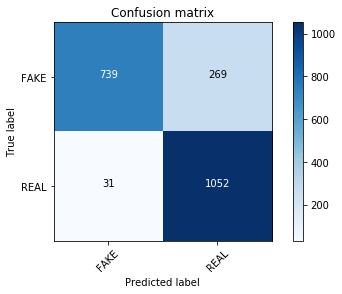

In [23]:
clf.fit(tfidf_train, y_train)
pred = clf.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [24]:
clf = MultinomialNB() 

accuracy:   0.893
Confusion matrix, without normalization


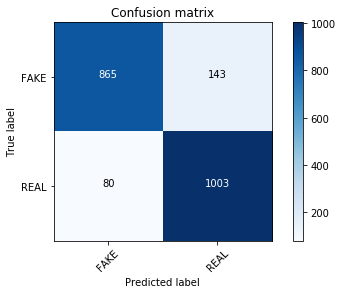

In [25]:
clf.fit(count_train, y_train)
pred = clf.predict(count_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

accuracy:   0.862
Confusion matrix, without normalization


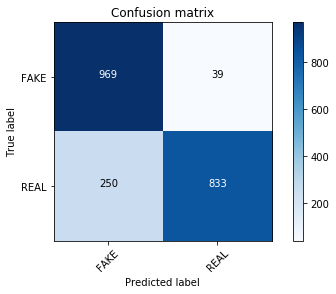

In [26]:
from sklearn import svm
clf=svm.SVC()
clf.fit(count_train, y_train)
pred = clf.predict(count_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

And indeed, with absolutely no parameter tuning, your count vectorized training set `count_train` is visibly outperforming your TF-IDF vectors!

### Testing Linear Models

There are a lot of great write-ups about how linear models work well with TF-IDF vectorizers (take a look at [word2vec for classification](http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/), [SVM reference in scikit-learn text analysis](http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html#evaluation-of-the-performance-on-the-test-set), and many more). 

So you should use a SVM, right? 

Well, I recently watched [Victor Lavrenko's lecture on text classification]( https://www.youtube.com/watch?v=4LINLfsq1yE&list=PLBv09BD7ez_4XyTO5MnDLV9N-s6kgXQy7) and he compares Passive Aggressive classifiers to linear SVMs for text classification. We'll test this approach (which has some significant speed benefits and permanent learning disadvantages) with the fake news dataset. 

In [27]:
linear_clf = PassiveAggressiveClassifier(max_iter=50)

accuracy:   0.936
Confusion matrix, without normalization


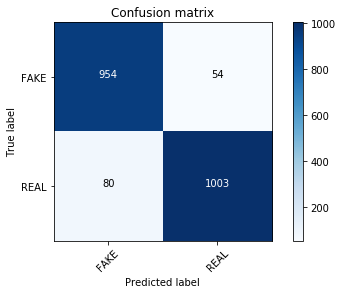

In [28]:
linear_clf.fit(tfidf_train, y_train)
pred = linear_clf.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

Wow! 

I'm impressed. The confusion matrix looks different and the model classifies our fake news a bit better. We can test if tuning the `alpha` value for a `MultinomialNB` creates comparable results. You can also use [parameter tuning with grid search](http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html#parameter-tuning-using-grid-search) for a more exhaustive search.

In [29]:
clf = MultinomialNB(alpha=0.1)

In [30]:
last_score = 0
for alpha in np.arange(0,1,.1):
    nb_classifier = MultinomialNB(alpha=alpha)
    nb_classifier.fit(tfidf_train, y_train)
    pred = nb_classifier.predict(tfidf_test)
    score = metrics.accuracy_score(y_test, pred)
    if score > last_score:
        clf = nb_classifier
    print("Alpha: {:.2f} Score: {:.5f}".format(alpha, score))

/home/disaster/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Alpha: 0.00 Score: 0.88140
Alpha: 0.10 Score: 0.89766
Alpha: 0.20 Score: 0.89383
Alpha: 0.30 Score: 0.89000
Alpha: 0.40 Score: 0.88570
Alpha: 0.50 Score: 0.88427
Alpha: 0.60 Score: 0.87470
Alpha: 0.70 Score: 0.87040
Alpha: 0.80 Score: 0.86609
Alpha: 0.90 Score: 0.85892


Not quite... At this point, it might be interesting to perform parameter tuning across all of the classifiers, or take a look at some other [scikit-learn Bayesian classifiers](http://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes). You could also test with a Support Vector Machine (SVM) to see if that outperforms the Passive Aggressive classifier.

But I am a bit more curious about what the Passive Aggressive model actually *has* learned. So let's move onto introspection.

### Introspecting models

So fake news is solved, right? We achieved 93% accuracy on my dataset so let's all close up shop and go home. 😂

Not quite, of course. I am wary at best of these results given how much noise we saw in the features. There is a great write-up [on StackOverflow](https://stackoverflow.com/a/26980472) with this incredibly useful function for finding vectors that most affect labels. It only works for binary classificaiton (classifiers with 2 classes), but that's good news for you, since you only have FAKE or REAL labels. 

Using your best performing classifier with your TF-IDF vector dataset (`tfidf_vectorizer`) and Passive Aggressive classifier (`linear_clf`), inspect the top 30 vectors for fake and real news:

In [31]:
def most_informative_feature_for_binary_classification(vectorizer, classifier, n=100):
    """
    See: https://stackoverflow.com/a/26980472
    
    Identify most important features if given a vectorizer and binary classifier. Set n to the number
    of weighted features you would like to show. (Note: current implementation merely prints and does not 
    return top classes.)
    """

    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]

    for coef, feat in topn_class1:
        print(class_labels[0], coef, feat)

    print()

    for coef, feat in reversed(topn_class2):
        print(class_labels[1], coef, feat)


most_informative_feature_for_binary_classification(tfidf_vectorizer, linear_clf, n=30)

FAKE -4.893230471899541 2016
FAKE -4.095526078747741 hillary
FAKE -4.062905330272522 october
FAKE -3.132522920646684 november
FAKE -3.1309746265010574 share
FAKE -2.944522136404656 article
FAKE -2.5875993139885085 print
FAKE -2.466047962506477 source
FAKE -2.369658091460597 email
FAKE -2.195784625566675 advertisement
FAKE -2.1892197958248922 nov
FAKE -2.1850122349777177 mosul
FAKE -2.1397782814011186 election
FAKE -2.094152605259548 establishment
FAKE -2.0741998340725267 podesta
FAKE -2.068974863764522 war
FAKE -2.031810088391953 oct
FAKE -1.9801548655577834 wikileaks
FAKE -1.8451271884566418 donald
FAKE -1.838339460116166 youtube
FAKE -1.792388073626557 snip
FAKE -1.790853381590612 26
FAKE -1.7762134529212603 corporate
FAKE -1.7122897332474885 jewish
FAKE -1.6723488942335676 ayotte
FAKE -1.668608538171316 brexit
FAKE -1.6655392203743526 elect
FAKE -1.6537000125255483 com
FAKE -1.5972706902936489 mainstream
FAKE -1.5907786412762102 pipeline

REAL 4.74814046298213 said
REAL 2.6384922320

You can also do this in a pretty obvious way with only a few lines of Python, by zipping your coefficients to your features and taking a look at the top and bottom of your list.

In [32]:
feature_names = tfidf_vectorizer.get_feature_names()

In [33]:
### Most real
sorted(zip(clf.coef_[0], feature_names), reverse=True)[:20]

[(-6.257361214701583, 'trump'),
 (-6.494453094312678, 'said'),
 (-6.6539784739838845, 'clinton'),
 (-7.037944662867073, 'obama'),
 (-7.146539983381228, 'sanders'),
 (-7.215376008647511, 'president'),
 (-7.266562805741618, 'campaign'),
 (-7.2875931446681514, 'republican'),
 (-7.341118458599064, 'state'),
 (-7.341357110247905, 'cruz'),
 (-7.378312441985425, 'party'),
 (-7.44688067245789, 'new'),
 (-7.476288801154588, 'people'),
 (-7.547225599514773, 'percent'),
 (-7.5553074094582335, 'bush'),
 (-7.580150633909893, 'republicans'),
 (-7.5855405012652435, 'house'),
 (-7.634478172520314, 'voters'),
 (-7.648482443695299, 'rubio'),
 (-7.6734836186463795, 'states')]

In [34]:
### Most fake
sorted(zip(clf.coef_[0], feature_names))[:20]

[(-11.349866225220305, '0000'),
 (-11.349866225220305, '000035'),
 (-11.349866225220305, '0001'),
 (-11.349866225220305, '0001pt'),
 (-11.349866225220305, '000km'),
 (-11.349866225220305, '0011'),
 (-11.349866225220305, '006s'),
 (-11.349866225220305, '007'),
 (-11.349866225220305, '007s'),
 (-11.349866225220305, '008s'),
 (-11.349866225220305, '0099'),
 (-11.349866225220305, '00am'),
 (-11.349866225220305, '00p'),
 (-11.349866225220305, '00pm'),
 (-11.349866225220305, '014'),
 (-11.349866225220305, '015'),
 (-11.349866225220305, '018'),
 (-11.349866225220305, '01am'),
 (-11.349866225220305, '020'),
 (-11.349866225220305, '023')]

So, clearly there are certain words which might show political intent and source in the top fake features (such as the words corporate and establishment). 

Also, the real news data uses forms of the verb "to say" more often, likely because in newspapers and most journalistic publications sources are quoted directly ("German Chancellor Angela Merkel said..."). 

To extract the full list from your current classifier and take a look at each token (or easily compare tokens from classifier to classifier), you can easily export it like so.

In [35]:
tokens_with_weights = sorted(list(zip(feature_names, clf.coef_[0])))

#### Intermezzo: HashingVectorizer

Another vectorizer used sometimes for text classification is a `HashingVectorizer`. `HashingVectorizer`s require less memory and are faster (because they are sparse and use hashes rather than tokens) but are more difficult to introspect. You can read a bit more about the pros and cons of using [`HashingVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html) in the scikit-learn documentation if you are interested.

You can give it a try and compare its results versus the other vectorizers. It performs fairly well, with better results than the TF-IDF vectorizer using `MultinomialNB` (this is somewhat expected due to the same reasons `CountVectorizer`s perform better), but not as well as the TF-IDF vectorizer with Passive Aggressive linear algorithm.

In [36]:
hash_vectorizer = HashingVectorizer(stop_words='english', non_negative=True)
hash_train = hash_vectorizer.fit_transform(X_train)
hash_test = hash_vectorizer.transform(X_test)

TypeError: __init__() got an unexpected keyword argument 'non_negative'

In [ ]:
clf = MultinomialNB(alpha=.01)

In [ ]:
clf.fit(hash_train, y_train)
pred = clf.predict(hash_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [ ]:
clf = PassiveAggressiveClassifier(n_iter=50)

In [ ]:
clf.fit(hash_train, y_train)
pred = clf.predict(hash_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

### Conclusion

So was your fake news classifier experiment a success? Definitely not. 

But you did get to play around with a new dataset, test out some NLP classification models and introspect how successful they were? Yes. 👏

As expected from the outset, defining fake news with simple bag-of-words or TF-IDF vectors is an oversimplified approach. Especially with a multilingual dataset full of noisy tokens. If you hadn't taken a look at what your model had actually learned, you might have thought the model learned something meaningful. So, remember: always introspect your models (as best you can!).

I would be curious if you find other trends in the data I might have missed. I will be following up with a post on how different classifiers compare in terms of important features [on my blog](https://blog.kjamistan.com). If you spend some time researching and find anything interesting, feel free to share your findings and notes in the comments or you can always reach out on Twitter (I'm [@kjam](https://twitter.com/kjam)).

I hope you had some fun exploring a new NLP dataset with me!